## Understanding how the environment works


In [8]:
import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym

if __name__ == "__main__":
    # initiate environment
    env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)
    obs = env.reset()

    # iterate
    while True:
        # Select next action
        action = (
            env.action_space.sample()
        )  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2)  # FPS

        # If player is dead break
        if done:
            break

    env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=0)
Text Flappy Bird!
Score: 0
----------------------
[      

In [9]:
import scipy
import numpy as np


# Ausiliary function
def discount_cumsum(x, discount):
    """
    magic for computing discounted cumulative sums of vectors.
    input:
        vector x,
        [x0,
         x1,
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

In [10]:
env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

In [4]:
obs = env.reset()
print(obs)
os.system("clear")
sys.stdout.write(env.render())
time.sleep(0.2)

((13, 0), {'score': 0, 'player': [6, 7], 'distance': 13.0})
Text Flappy Bird!
Score: 0
----------------------
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                    ]
[                    ]
[      @             ]
[                    ]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=13,dy=0)


In [5]:
action = env.action_space.sample()  # for an agent, action = agent.policy(observation)
print("action", action)
# Appy action and return new observation of the environment
obs, reward, done, _, info = env.step(action)

print("obs", obs, "\nreward", reward, "\ndone", done, "\ninfo", info)

action 1
obs (12, -1) 
reward 1 
done False 
info {'score': 0, 'player': [6, 6], 'distance': 12.041594578792296}


# Trying to implement SARSA($\lambda$)

In [6]:
class SARSA_Lambda:
    def __init__(self, space_size, action_size, gamma=1, lr_v=0.01, lambda_ = 0.2):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """
        # the discount factor
        self.gamma = gamma

        self.lambda_ = lambda_
        # size of system
        self.space_size = space_size  # as tuple
        self.action_size = action_size

        # the learning rate
        self.lr_v = lr_v

        # the eligibility traces
        self.et = np.zeros((*self.space_size, self.action_size))

        # where to save returns
        self.Qvalues = np.zeros((*self.space_size, self.action_size))
        

    # -------------------
    def single_step_update(self, s, a, r, new_s, new_a, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        self.et[(*s, a)] += 1
        if done:
            # CODE HERE!
            # deltaQ = R - Q(s,a)
            
            deltaQ = r + 0 - self.Qvalues[(*s, a)]
            self.Qvalues += self.lr_v*deltaQ*self.et
            """
            for x in range(env.observation_space[0].n):
                for y in range(env.observation_space[1].n):
                    y = y + env.observation_space[1].start
                    state = (x, y)
                    for act in range(self.action_size):
                        self.Qvalues[(*state, act)] += self.lr_v*deltaQ*self.et[(*state, act)]
                        # self.et[(*state, act)] *= self.gamma*self.lambda_
            """
        else:
            # CODE HERE!
            # deltaQ = R + gamma*Q(new_s, new_a) - Q(s,a)
            deltaQ = (
                r + self.gamma * self.Qvalues[(*new_s, new_a)] - self.Qvalues[(*s, a)]
            )
            self.Qvalues += self.lr_v*deltaQ*self.et
            self.et *= self.gamma*self.lambda_
            """
            for x in range(env.observation_space[0].n):
                for y in range(env.observation_space[1].n):
                    y = y + env.observation_space[1].start
                    state = (x, y)
                    for act in range(self.action_size):
                        self.Qvalues[(*state, act)] += self.lr_v*deltaQ*self.et[(*state, act)]
                        self.et[(*state, act)] *= self.gamma*self.lambda_
            """

    # ---------------------
    def get_action_epsilon_greedy(self, s, eps):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """
        ran = np.random.rand()

        # CODE HERE!

        if ran < eps:
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size

        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[(*s,)])

            # There could be actions with equal value!
            best_actions = self.Qvalues[(*s,)] == best_value

            # best_actions is
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)

        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a

    def greedy_policy(self):
        # CODE HERE!

        a = np.argmax(self.Qvalues, axis=2)
        return a

In [55]:
n_episodes = 10000
Actions = [0, 1]  # flap / no flap
observation_space = (env.observation_space[0].n, env.observation_space[1].n)

# Initialize
SARSA_lambda = SARSA_Lambda(
    space_size=observation_space, action_size=2, gamma=1, lr_v=0.15, lambda_ = 0.8
)

# Initialize 
epsilon0 = 0.2
lr_v0 = 0.15

epsilon = epsilon0

count = 0
tstar = 25000

performance_traj_SARSA_Lambda = np.zeros(n_episodes)

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    s, info = env.reset()
    a = SARSA_lambda.get_action_epsilon_greedy(s, epsilon)
    act = Actions[a]

    while not done:
        count += 1
        # for _ in range(100):
        # Evolve one step
        new_s, r, done, _, info = env.step(act)

        # Keeps track of performance for each episode
        performance_traj_SARSA_Lambda[i] += r

        # Choose new action index
        new_a = SARSA_lambda.get_action_epsilon_greedy(new_s, epsilon)
        # print(s,act,a, r,new_s,new_a, done, ' Qvalue ', SARSA.Qvalues[(*s,)])
        # (Corresponding action to index)
        act = Actions[new_a]
        # Single update with (S, A, R', S', A')
        SARSA_lambda.single_step_update(s, a, r, new_s, new_a, done)

        if count > tstar:
            epsilon = epsilon0/(1. + 0.0005*(count - tstar)**1.05)
            SARSA_lambda.lr_v = lr_v0/(1 + 0.003*(count - tstar)**0.75)

        a = new_a
        s = new_s

Qvalues = SARSA_lambda.Qvalues

In [56]:
plot_indexes = np.arange(
    0, n_episodes + 1, 20, dtype=int
)  # Only plot a sub-plot of results
plot_indexes[-1] = plot_indexes[-1] - 1

Text(0.5, 1.0, 'SARSA cumulative rewards')

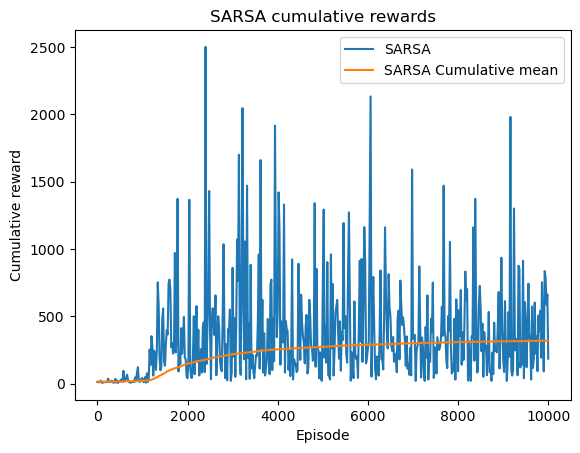

In [57]:
import matplotlib.pyplot as plt

cumulative_mean_SARSA_Lambda = np.cumsum(performance_traj_SARSA_Lambda) / np.arange(
    1, len(performance_traj_SARSA_Lambda) + 1
)

plt.plot(plot_indexes, performance_traj_SARSA_Lambda[plot_indexes], label="SARSA")
plt.plot(
    plot_indexes, cumulative_mean_SARSA_Lambda[plot_indexes], label="SARSA Cumulative mean"
)
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.legend()
plt.title("SARSA cumulative rewards")

Text(0.5, 1.0, 'SARSA cumulative rewards')

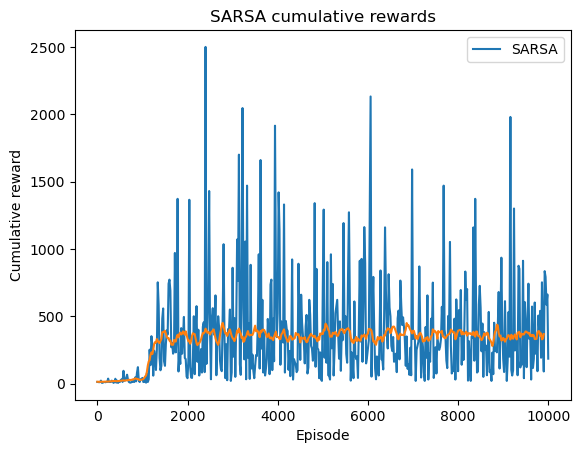

In [58]:
window_size = 100
local_mean_SARSA_Lambda = np.convolve(
    performance_traj_SARSA_Lambda, np.ones(window_size) / window_size, mode="valid"
)
local_mean_SARSA_Lambda.shape


plt.plot(plot_indexes, performance_traj_SARSA_Lambda[plot_indexes], label="SARSA")
plt.plot(
    plot_indexes[plot_indexes < local_mean_SARSA_Lambda.shape[0]],
    local_mean_SARSA_Lambda[plot_indexes[plot_indexes < local_mean_SARSA_Lambda.shape[0]]],
)
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.legend()
plt.title("SARSA cumulative rewards")

In [151]:
def plot_state_value():
    """
    Function to plot which is the best action for each state
    """
    dimx = self.Qvalues.shape[0]
    dimy= self.Qvalues.shape[1]
    for x in range(dimx):
        for y in range(dimy):
            if(self.Qvalues[x][y][0] == 0.0 and self.Qvalues[x][y][1] == 0.0):
                newQ[x][y] = -1
            elif(self.Qvalues[x][y][0] > self.Qvalues[x][y][1]):
                newQ[x][y] = 0
            else:
                newQ[x][y] = 1
    finalQ = np.zeros((self.Qvalues.shape[0],self.Qvalues.shape[1]))
    for i in range(self.Qvalues.shape[0]):
        for j in range(self.Qvalues.shape[1]):
            if(j <= 11):
                finalQ[i][j+10] = newQ[i][j]
            else:
                finalQ[i][j-12] = newQ[i][j]
    finalQ = finalQ.transpose()

    # Create plot
    fig = plt.figure(figsize=(10, 10))
    plt.xticks(xx)
    plt.yticks(yy)
    im = plt.imshow(finalQ, extent=[0, 14, -11, 11])
    plt.grid(color='w', linestyle='-', linewidth=1)
    labels = ['Not visited', '0 (Idle)', '1 (Flap)']
    colorbar = plt.colorbar(im, ticks=[-1, 0, 1])
    colorbar.ax.set_yticklabels(['Not visited', '0 (Idle)', '1 (Flap)'])

In [152]:
newQ = np.zeros((SARSA_lambda.Qvalues.shape[0],SARSA_lambda.Qvalues.shape[1]))
for x in range(SARSA_lambda.Qvalues.shape[0]):
    for y in range(SARSA_lambda.Qvalues.shape[1]):
        if(SARSA_lambda.Qvalues[x][y][0] == 0.0 and SARSA_lambda.Qvalues[x][y][1] == 0.0):
            newQ[x][y] = -1
        elif(SARSA_lambda.Qvalues[x][y][0] > SARSA_lambda.Qvalues[x][y][1]):
            newQ[x][y] = 0
        else:
            newQ[x][y] = 1

In [153]:
finalQ = np.zeros((SARSA_lambda.Qvalues.shape[0],SARSA_lambda.Qvalues.shape[1]))
for i in range(SARSA_lambda.Qvalues.shape[0]):
    for j in range(SARSA_lambda.Qvalues.shape[1]):
        if(j <= 11):
            finalQ[i][j+10] = newQ[i][j]
        else:
            finalQ[i][j-12] = newQ[i][j]
finalQ = finalQ.transpose()

[Text(1, -1, 'Not visited'), Text(1, 0, '0 (Idle)'), Text(1, 1, '1 (Flap)')]

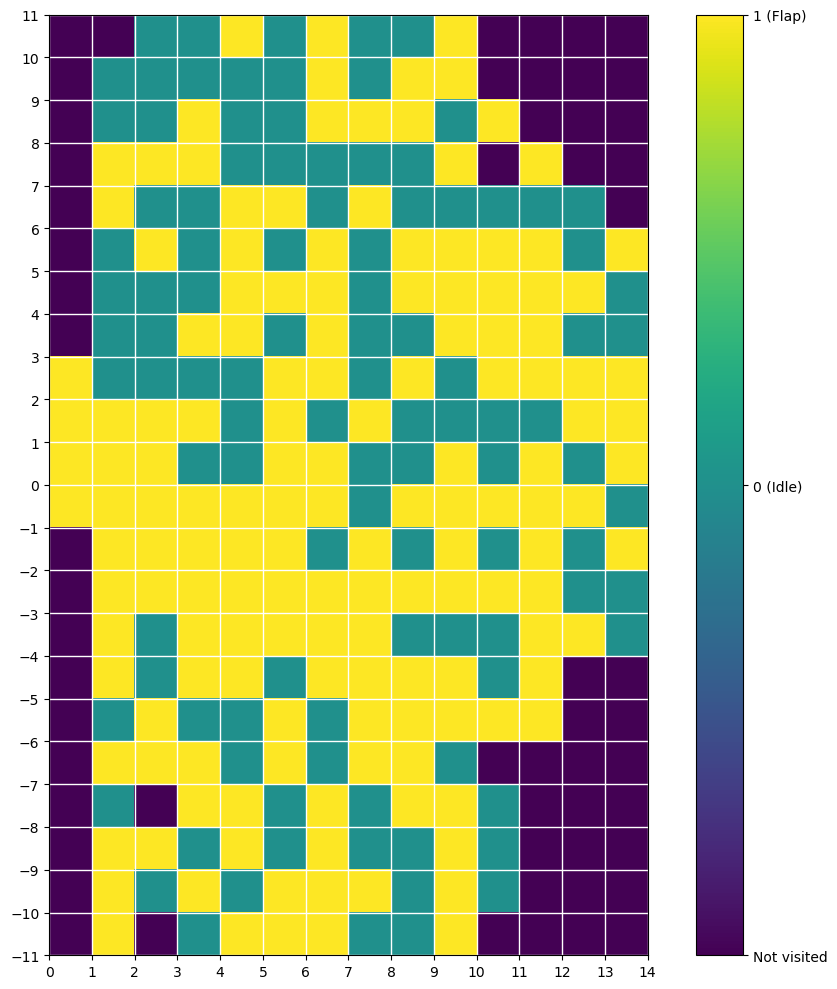

In [156]:
xx = np.arange(0,15,1)
yy = np.arange(-11,12,1)
fig = plt.figure(figsize=(10, 10))
plt.xticks(xx)
plt.yticks(yy)
im = plt.imshow(finalQ, extent=[0, 14, -11, 11])
plt.grid(color='w', linestyle='-', linewidth=1)
labels = ['Not visited', '0 (Idle)', '1 (Flap)']
colorbar = plt.colorbar(im, ticks=[-1, 0, 1])
colorbar.ax.set_yticklabels(['Not visited', '0 (Idle)', '1 (Flap)'])

# Trying to implement Q-Lambda to see if they work


In [15]:
class Qlearning_Lambda:
    def __init__(self, space_size, action_size, gamma=1, lr_v=0.15, lambda_ = 0.2):
        """
        Calculates optimal policy using off-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """
        # the discount factor
        self.gamma = gamma
        # size of system
        self.space_size = space_size  # as tuple
        self.action_size = action_size

        # the learning rate
        self.lr_v = lr_v

        self.lambda_ = lambda_

        self.old_action = None

        # the eligibility traces
        self.et = np.zeros((*self.space_size, self.action_size))

        # where to save returns
        self.Qvalues = np.zeros((*self.space_size, self.action_size))

    # -------------------
    def single_step_update(self, s, a, r, new_s, done):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Uses the BEST (evaluated) action in the new state <- Q(S_new, A*) = max_A Q(S_new, A).
        """
        if self.old_action is not None and a != self.old_action:
            self.et = np.zeros((*self.space_size, self.action_size))
        else:
            self.et *= self.gamma*self.lambda_       
        
        
        self.et[(*s, a)] += 1
        if done:
            # CODE HERE !
            # deltaQ = R - Q(s,a)

            deltaQ = r + 0 - self.Qvalues[(*s, a)]
            self.Qvalues += self.lr_v*deltaQ*self.et
        else:
            # CODE HERE!
            # deltaQ = R + gamma*max_act Q(new_s, act)- Q(s,a)

            maxQ_over_actions = np.max(self.Qvalues[(*new_s,)])
            a_star = np.argmax(self.Qvalues[(*new_s,)])
            self.old_action = a_star

            deltaQ = r + self.gamma * maxQ_over_actions - self.Qvalues[(*s, a)]

            self.Qvalues += self.lr_v*deltaQ*self.et
            # if ==a_star:
                # self.et *= self.gamma*self.lambda_

        # self.Qvalues[(*s, a)] += self.lr_v * deltaQ

    # ---------------------
    def get_action_epsilon_greedy(self, s):
        """
        Chooses action at random using an epsilon-greedy policy wrt the current Q(s,a).
        """

        ran = np.random.rand()

        if ran < self.epsilon:
            # probability is uniform for all actions!
            prob_actions = np.ones(self.action_size) / self.action_size

        else:
            # I find the best Qvalue
            best_value = np.max(self.Qvalues[(*s,)])

            # There could be actions with equal value!
            best_actions = self.Qvalues[(*s,)] == best_value

            # best_actions is
            # *True* if the value is equal to the best (possibly ties)
            # *False* if the action is suboptimal
            prob_actions = best_actions / np.sum(best_actions)

        # take one action from the array of actions with the probabilities as defined above.
        a = np.random.choice(self.action_size, p=prob_actions)
        return a

    def greedy_policy(self):
        a = np.argmax(self.Qvalues, axis=2)
        return a

In [16]:
# Q-Learning Control
n_episodes = 10000
Actions = [0, 1]  # flap / no flap
observation_space = (env.observation_space[0].n, env.observation_space[1].n)


# Initialize
QLearning_lambda = Qlearning_Lambda(
    space_size=observation_space, action_size=2, gamma=1, lr_v=0.15
)
# Initialize 
epsilon0 = 0.2
lr_v0 = 0.15

epsilon = epsilon0
lr = lr_v0

k_e = 0.05
k_lr = 0.00003

count = 0
tstar = 25000


performance_traj_Q_Lambda = np.zeros(n_episodes)

# RUN OVER EPISODES
for i in range(n_episodes):
    done = False

    s, info = env.reset()
    QLearning_lambda.epsilon = epsilon0
    QLearning_lambda.lr_v = lr_v0
    
    a = QLearning_lambda.get_action_epsilon_greedy(s)
    act = Actions[a]

    while not done:
        count += 1
        # for _ in range(100):
        # Evolve one step
        new_s, r, done, _, info = env.step(act)

        # Keeps track of performance for each episode
        performance_traj_Q_Lambda[i] += r

        # Choose new action index
        new_a = QLearning_lambda.get_action_epsilon_greedy(new_s)
        # print(s,act,a, r,new_s,new_a, done, ' Qvalue ', SARSA.Qvalues[(*s,)])
        # (Corresponding action to index)
        act = Actions[new_a]
        # Single update with (S, A, R', S')
        QLearning_lambda.single_step_update(s, a, r, new_s, done)

        if count > tstar:
            epsilon = epsilon0/(1. + k_e*(count - tstar)**1.05)
            QLearning_lambda.lr_v = lr_v0/(1 + k_lr*(count - tstar)**0.75)

        a = new_a
        s = new_s

Qvalues_QLearning = QLearning_lambda.Qvalues

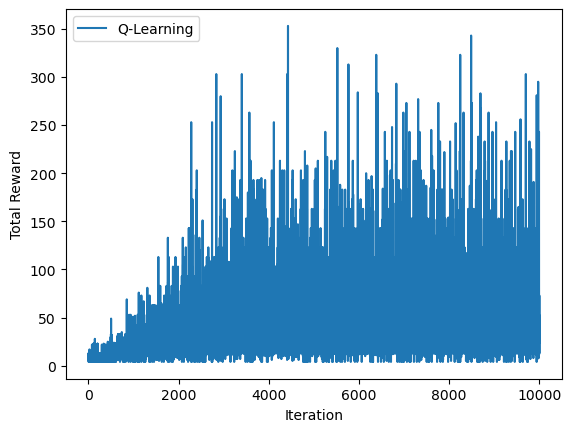

In [18]:
import matplotlib.pyplot as plt

plt.plot(performance_traj_Q_Lambda, label="Q-Learning")
# plt.plot(plot_indexes, performance_traj_SARSA_Lambda[plot_indexes], label="SARSA")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Total Reward")
plt.show()